In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob, os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn

## all compounds under GABAA allosteric antagonist+ GABAA pore blocker+TRPV agonist and some compounds in WT

In [2]:
data = pd.read_csv("./C5-C129/data_median_all/four_classes_labels_order.csv")
data

,Unnamed: 0,Pre: Q1,Pre: Q3,L1: Q1,L1: Q3,E1: Q1,E1: Q3,E2: Q1,E2: Q3,E3: Q1,E3: Q3,R1: Q1,R1: Q3,R2: Q1,R2: Q3,action mode
0,C27,0.027249,0.031506,0.029611,0.129795,0.039128,0.076689,0.026315,0.032792,0.025249,0.026433,0.025199,0.026304,0.025202,0.026295,GABAA allosteric antagonist
1,C28,0.026180,0.033146,0.026878,0.046242,0.031440,0.069519,0.028271,0.033913,0.026474,0.028895,0.026061,0.028682,0.024845,0.027314,GABAA allosteric antagonist
2,C29,0.028139,0.032934,0.030115,0.056096,0.036811,0.076576,0.028313,0.032292,0.027322,0.028915,0.027177,0.030526,0.026999,0.027695,GABAA allosteric antagonist
3,C34,0.028144,0.031363,0.032394,0.191891,0.051607,0.166796,0.029490,0.036784,0.028252,0.029385,0.027982,0.029160,0.027957,0.028956,GABAA allosteric antagonist
4,C36,0.033823,0.037328,0.037380,0.128150,0.042277,0.103168,0.034668,0.038230,0.032083,0.034245,0.031786,0.033923,0.031182,0.033820,GABAA allosteric antagonist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,WT_Control_10,0.028009,0.029890,0.030927,0.089533,0.040826,0.109981,0.029054,0.032836,0.026759,0.028354,0.026825,0.028088,0.026933,0.028652,WT_control
146,WT_Control_4,0.019959,0.025532,0.028686,0.157195,0.030004,0.108097,0.020531,0.028304,0.019440,0.020346,0.019728,0.020527,0.021804,0.022363,WT_control
147,WT_Control_5,0.023917,0.026203,0.031742,0.232738,0.094684,0.210205,0.027121,0.037384,0.024733,0.026254,0.024837,0.026551,0.025052,0.027729,WT_control
148,WT_Control_11,0.025712,0.028093,0.028556,0.040457,0.033479,0.147039,0.025612,0.029532,0.025584,0.026810,0.025069,0.026116,0.024893,0.027009,WT_control


In [6]:
file = data["Unnamed: 0"][0]
datasum = pd.read_csv("./C5-C129/cleaned_data/{}.csv".format(file))
datasum = datasum.T
ilist = [file+"_"+str(i).zfill(2) for i in range(len(datasum))]
datasum = datasum.reset_index(drop=True)
datasum.insert(0, 'index', pd.Series(ilist)) # add the new index C27_00, C27_01...
datasum["action mode"] = data["action mode"][0] # add the labels to each fish
datasum

,index,0,1,2,3,4,5,6,7,8,...,532,533,534,535,536,537,538,539,540,action mode
0,C27_00,0.027233,0.027539,0.027299,0.027645,0.027516,0.027216,0.026913,0.027065,0.027211,...,0.035469,0.033350,0.032376,0.031603,0.030481,0.030428,0.033246,0.033398,0.035958,GABAA allosteric antagonist
1,C27_01,0.034097,0.033132,0.033106,0.034465,0.033873,0.035325,0.035155,0.035615,0.033612,...,0.033993,0.033235,0.036673,0.035707,0.032408,0.034262,0.033855,0.035080,0.034525,GABAA allosteric antagonist
2,C27_02,0.022425,0.022276,0.022578,0.021829,0.021994,0.021960,0.021944,0.022157,0.022356,...,0.007974,0.008208,0.008466,0.008117,0.007963,0.008235,0.008228,0.008159,0.008054,GABAA allosteric antagonist
3,C27_03,0.116440,0.098673,0.095889,0.085707,0.083466,0.076944,0.073436,0.067148,0.063102,...,0.020565,0.020161,0.021047,0.021765,0.021712,0.022141,0.020585,0.020312,0.020073,GABAA allosteric antagonist
4,C27_04,0.034495,0.034277,0.032969,0.033982,0.032666,0.032558,0.032460,0.034080,0.033181,...,0.035469,0.033350,0.032376,0.031603,0.030481,0.030428,0.033246,0.033398,0.035958,GABAA allosteric antagonist
5,C27_05,0.024249,0.022926,0.022479,0.021941,0.021576,0.023885,0.022837,0.025708,0.025860,...,0.029055,0.027382,0.028638,0.029175,0.027788,0.028022,0.026890,0.028178,0.028496,GABAA allosteric antagonist
6,C27_06,0.029191,0.031238,0.028460,0.028564,0.029721,0.028968,0.029907,0.028326,0.030609,...,0.013406,0.013422,0.013389,0.013707,0.013555,0.013677,0.013702,0.013642,0.013770,GABAA allosteric antagonist
7,C27_07,0.037747,0.038571,0.039152,0.042519,0.039322,0.041720,0.040968,0.039336,0.038025,...,0.015625,0.015782,0.015821,0.015741,0.015804,0.015940,0.015673,0.015848,0.015692,GABAA allosteric antagonist
8,C27_08,0.048824,0.043615,0.041148,0.036997,0.036814,0.033047,0.030833,0.029660,0.027328,...,0.011408,0.011525,0.011612,0.011929,0.011610,0.011500,0.011531,0.011404,0.011279,GABAA allosteric antagonist
9,C27_09,0.029609,0.031233,0.031471,0.030536,0.029614,0.028527,0.029952,0.029852,0.031101,...,0.035461,0.034992,0.033422,0.032187,0.033132,0.032830,0.034335,0.036439,0.034309,GABAA allosteric antagonist


In [17]:
#for i in range(len(data["Unnamed: 0"][1:])): #fault, because you select first one C27 again.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148


In [7]:
#right
for i in data["Unnamed: 0"][1:95].index:
    file_name = data["Unnamed: 0"][i]
    #print(file_name)
    df = pd.read_csv("./C5-C129/cleaned_data/{0}.csv".format(file_name))
    df = df.T
    df = df.reset_index(drop=True)
    ilist = [file_name+"_"+str(j).zfill(2) for j in range(len(df))]
    df.insert(0, 'index', pd.Series(ilist))
    df["action mode"] = data["action mode"][i]
    #df.to_csv("./C5-C129/data_frames_labeled/each compound/{0}.csv".format(file_name), index=None)
    datasum = pd.concat([datasum, df], axis=0)
    
datasum.to_csv("./C5-C129/data_frames_labeled/effected_frames_labeled.csv", index=None)

In [ ]:
#collect WT

In [44]:
f = glob.glob("./C5-C129/cleaned_data/WT/*.csv")

datasum_WT = pd.read_csv(f[0])
datasum_WT = datasum_WT.T
datasum_WT = datasum_WT.reset_index(drop=True)

for file in f[1:]:
    df = pd.read_csv(file)
    df = df.T
    df = df.reset_index(drop=True)
    datasum_WT = pd.concat([datasum_WT, df], axis=0)

datasum_WT = datasum_WT.reset_index(drop=True)
print (datasum_WT.index)


RangeIndex(start=0, stop=589, step=1)


In [45]:
wt_list = ["WT_Control_"+str(i).zfill(3) for i in range(len(datasum_WT))]
datasum_WT.insert(0, 'index', pd.Series(wt_list))
datasum_WT["action mode"] = "WT_control"
datasum_WT.to_csv("./C5-C129/data_frames_labeled/WT_frames_labeled.csv", index=None)
    

In [47]:
data_all = pd.concat([datasum, datasum_WT], axis=0)
data_all.to_csv("./C5-C129/data_frames_labeled/effected_all_frames_labeled.csv", index=None)

### MLP

In [48]:
df = pd.read_csv("./C5-C129/data_frames_labeled/effected_all_frames_labeled.csv")
df

,index,0,1,2,3,4,5,6,7,8,...,532,533,534,535,536,537,538,539,540,action mode
0,C27_00,0.027233,0.027539,0.027299,0.027645,0.027516,0.027216,0.026913,0.027065,0.027211,...,0.035469,0.033350,0.032376,0.031603,0.030481,0.030428,0.033246,0.033398,0.035958,GABAA allosteric antagonist
1,C27_01,0.034097,0.033132,0.033106,0.034465,0.033873,0.035325,0.035155,0.035615,0.033612,...,0.033993,0.033235,0.036673,0.035707,0.032408,0.034262,0.033855,0.035080,0.034525,GABAA allosteric antagonist
2,C27_02,0.022425,0.022276,0.022578,0.021829,0.021994,0.021960,0.021944,0.022157,0.022356,...,0.007974,0.008208,0.008466,0.008117,0.007963,0.008235,0.008228,0.008159,0.008054,GABAA allosteric antagonist
3,C27_03,0.116440,0.098673,0.095889,0.085707,0.083466,0.076944,0.073436,0.067148,0.063102,...,0.020565,0.020161,0.021047,0.021765,0.021712,0.022141,0.020585,0.020312,0.020073,GABAA allosteric antagonist
4,C27_04,0.034495,0.034277,0.032969,0.033982,0.032666,0.032558,0.032460,0.034080,0.033181,...,0.035469,0.033350,0.032376,0.031603,0.030481,0.030428,0.033246,0.033398,0.035958,GABAA allosteric antagonist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,WT_Control_584,0.012645,0.012774,0.012832,0.012799,0.012655,0.012602,0.012633,0.012648,0.012643,...,0.012822,0.012893,0.012789,0.012867,0.012767,0.012748,0.012829,0.012829,0.012859,WT_control
4799,WT_Control_585,0.023257,0.022263,0.022948,0.021674,0.023818,0.023273,0.022829,0.021736,0.022251,...,0.023851,0.022643,0.023834,0.022680,0.023417,0.023315,0.023172,0.022639,0.021779,WT_control
4800,WT_Control_586,0.027347,0.026401,0.025863,0.025242,0.025504,0.025884,0.025644,0.025481,0.025876,...,0.023123,0.023913,0.025340,0.025306,0.023730,0.024275,0.023605,0.022926,0.022167,WT_control
4801,WT_Control_587,0.024743,0.024200,0.024444,0.023782,0.025545,0.025843,0.025644,0.024599,0.024149,...,0.024652,0.028002,0.025262,0.028470,0.026199,0.025387,0.024102,0.028028,0.025369,WT_control


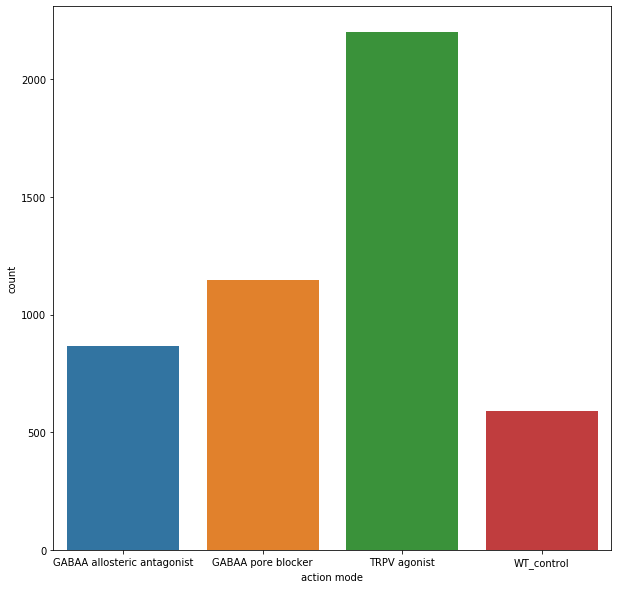

In [53]:
plt.figure(figsize=(10, 10))
sns.countplot(x='action mode', data=df)
plt.savefig("./C5-C129/data_frames_labeled/four_distribution_allfishes.png", dpi=300)

In [56]:
le=LabelEncoder()
X=df.iloc[:, 1:-1]
Y=le.fit_transform(df['action mode'])

In [57]:
class2idx = {
    'GABAA allosteric antagonist':0,
    'GABAA pore blocker':1,
    'TRPV agonist':2,
    'WT_control':3,
}

idx2class = {v: k for k, v in class2idx.items()}

df['action mode'].replace(class2idx, inplace=True)

In [58]:
X

,0,1,2,3,4,5,6,7,8,9,...,531,532,533,534,535,536,537,538,539,540
0,0.027233,0.027539,0.027299,0.027645,0.027516,0.027216,0.026913,0.027065,0.027211,0.027248,...,0.035112,0.035469,0.033350,0.032376,0.031603,0.030481,0.030428,0.033246,0.033398,0.035958
1,0.034097,0.033132,0.033106,0.034465,0.033873,0.035325,0.035155,0.035615,0.033612,0.034037,...,0.034600,0.033993,0.033235,0.036673,0.035707,0.032408,0.034262,0.033855,0.035080,0.034525
2,0.022425,0.022276,0.022578,0.021829,0.021994,0.021960,0.021944,0.022157,0.022356,0.021943,...,0.008156,0.007974,0.008208,0.008466,0.008117,0.007963,0.008235,0.008228,0.008159,0.008054
3,0.116440,0.098673,0.095889,0.085707,0.083466,0.076944,0.073436,0.067148,0.063102,0.059446,...,0.021132,0.020565,0.020161,0.021047,0.021765,0.021712,0.022141,0.020585,0.020312,0.020073
4,0.034495,0.034277,0.032969,0.033982,0.032666,0.032558,0.032460,0.034080,0.033181,0.034841,...,0.035112,0.035469,0.033350,0.032376,0.031603,0.030481,0.030428,0.033246,0.033398,0.035958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,0.012645,0.012774,0.012832,0.012799,0.012655,0.012602,0.012633,0.012648,0.012643,0.012804,...,0.012812,0.012822,0.012893,0.012789,0.012867,0.012767,0.012748,0.012829,0.012829,0.012859
4799,0.023257,0.022263,0.022948,0.021674,0.023818,0.023273,0.022829,0.021736,0.022251,0.023746,...,0.023855,0.023851,0.022643,0.023834,0.022680,0.023417,0.023315,0.023172,0.022639,0.021779
4800,0.027347,0.026401,0.025863,0.025242,0.025504,0.025884,0.025644,0.025481,0.025876,0.025694,...,0.023655,0.023123,0.023913,0.025340,0.025306,0.023730,0.024275,0.023605,0.022926,0.022167
4801,0.024743,0.024200,0.024444,0.023782,0.025545,0.025843,0.025644,0.024599,0.024149,0.024176,...,0.024527,0.024652,0.028002,0.025262,0.028470,0.026199,0.025387,0.024102,0.028028,0.025369


In [59]:
Y.shape

(4803,)

In [60]:
le.classes_

array(['GABAA allosteric antagonist', 'GABAA pore blocker',
       'TRPV agonist', 'WT_control'], dtype=object)

In [61]:
le.inverse_transform([0,1,2,3])
dict(zip(le.inverse_transform([0,1,2,3]),[0,1,2,3]))

{'GABAA allosteric antagonist': 0,
 'GABAA pore blocker': 1,
 'TRPV agonist': 2,
 'WT_control': 3}

In [62]:

#Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=21)

In [65]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

In [66]:
def get_class_distribution(obj):
    count_dict = {
        "GABAA allosteric antagonist_": 0,
        "GABAA pore blocker_": 0,
        "TRPV agonist_": 0,
        "WT_control": 0,

    }
    
    for i in obj:
        if i == 0: 
            count_dict['GABAA allosteric antagonist_'] += 1
        elif i == 1: 
            count_dict['GABAA pore blocker_'] += 1
        elif i == 2: 
            count_dict['TRPV agonist_'] += 1 
        elif i == 3: 
            count_dict['WT_control'] += 1  
        else:
            print("Check classes.")
            
    return count_dict


Once we have the dictionary count, we use Seaborn library to plot the bar charts. The make the plot, we first convert our dictionary to a dataframe using pd.DataFrame.from_dict([get_class_distribution(y_train)]) . Subsequently, we .melt() our convert our dataframe into the long format and finally use sns.barplot() to build the plots.

Text(0.5, 1.0, 'Class Distribution in Val Set')

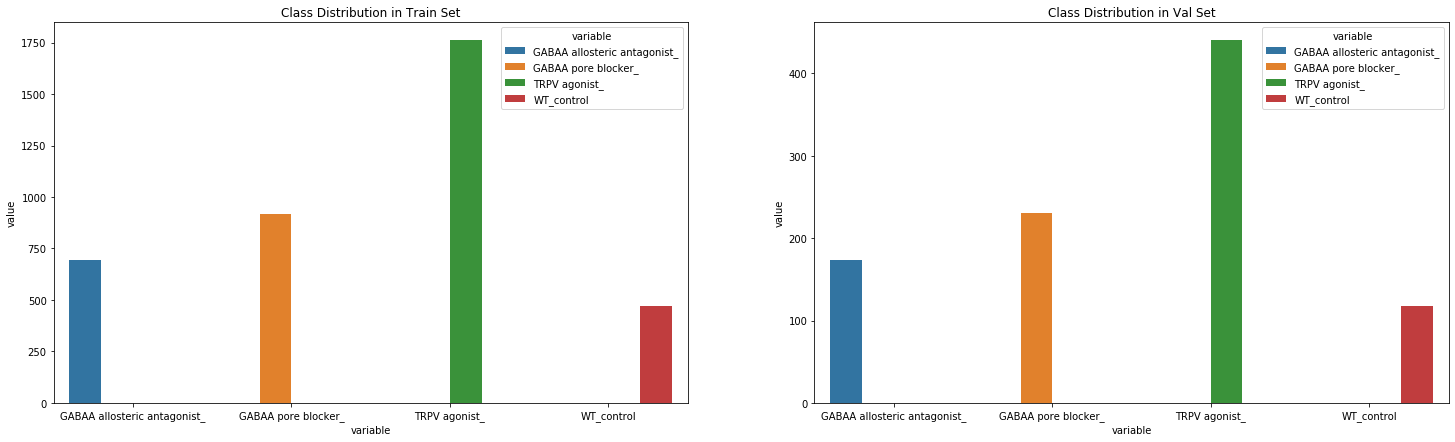

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')


In [70]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

In [71]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [72]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)


tensor([0.0014, 0.0011, 0.0006, 0.0021])


In [73]:
class_weights_all = class_weights[target_list]

In [74]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [75]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.00007

NUM_FEATURES = len(X.columns)
NUM_CLASSES = 4

In [76]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

In [77]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [78]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [79]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)



MulticlassClassification(
  (layer_1): Linear(in_features=541, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [80]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [81]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [82]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


Epoch 001: | Train Loss: 1.36117 | Val Loss: 1.36234 | Train Acc: 27.938| Val Acc: 31.842
Epoch 002: | Train Loss: 1.26342 | Val Loss: 1.30665 | Train Acc: 39.207| Val Acc: 36.004
Epoch 003: | Train Loss: 1.21257 | Val Loss: 1.30309 | Train Acc: 42.925| Val Acc: 35.796
Epoch 004: | Train Loss: 1.16141 | Val Loss: 1.27641 | Train Acc: 47.651| Val Acc: 36.629
Epoch 005: | Train Loss: 1.14068 | Val Loss: 1.28101 | Train Acc: 49.552| Val Acc: 36.524
Epoch 006: | Train Loss: 1.09913 | Val Loss: 1.24061 | Train Acc: 51.274| Val Acc: 39.958
Epoch 007: | Train Loss: 1.06687 | Val Loss: 1.26914 | Train Acc: 52.876| Val Acc: 37.357
Epoch 008: | Train Loss: 1.00739 | Val Loss: 1.25139 | Train Acc: 55.763| Val Acc: 37.461
Epoch 009: | Train Loss: 0.99387 | Val Loss: 1.26764 | Train Acc: 56.963| Val Acc: 37.565
Epoch 010: | Train Loss: 0.96416 | Val Loss: 1.29315 | Train Acc: 57.618| Val Acc: 35.796
Epoch 011: | Train Loss: 0.93143 | Val Loss: 1.30745 | Train Acc: 60.203| Val Acc: 35.796
Epoch 012:

Epoch 093: | Train Loss: 0.38035 | Val Loss: 1.94839 | Train Acc: 81.888| Val Acc: 39.126
Epoch 094: | Train Loss: 0.39341 | Val Loss: 1.92089 | Train Acc: 82.253| Val Acc: 40.375
Epoch 095: | Train Loss: 0.38823 | Val Loss: 2.03209 | Train Acc: 82.755| Val Acc: 36.316
Epoch 096: | Train Loss: 0.38428 | Val Loss: 1.87502 | Train Acc: 82.693| Val Acc: 38.918
Epoch 097: | Train Loss: 0.36568 | Val Loss: 2.02238 | Train Acc: 82.552| Val Acc: 38.189
Epoch 098: | Train Loss: 0.39191 | Val Loss: 2.02900 | Train Acc: 82.212| Val Acc: 41.207
Epoch 099: | Train Loss: 0.38684 | Val Loss: 2.08280 | Train Acc: 82.411| Val Acc: 40.479
Epoch 100: | Train Loss: 0.40989 | Val Loss: 2.00963 | Train Acc: 82.295| Val Acc: 38.398
Epoch 101: | Train Loss: 0.38570 | Val Loss: 2.04348 | Train Acc: 82.369| Val Acc: 40.375
Epoch 102: | Train Loss: 0.39440 | Val Loss: 2.02262 | Train Acc: 82.212| Val Acc: 38.293
Epoch 103: | Train Loss: 0.41432 | Val Loss: 2.04210 | Train Acc: 81.971| Val Acc: 38.918
Epoch 104:

Epoch 185: | Train Loss: 0.31757 | Val Loss: 2.34132 | Train Acc: 85.228| Val Acc: 38.606
Epoch 186: | Train Loss: 0.31301 | Val Loss: 2.36777 | Train Acc: 85.905| Val Acc: 41.103
Epoch 187: | Train Loss: 0.32723 | Val Loss: 2.32249 | Train Acc: 85.983| Val Acc: 39.438
Epoch 188: | Train Loss: 0.35983 | Val Loss: 2.33467 | Train Acc: 83.456| Val Acc: 38.398
Epoch 189: | Train Loss: 0.32009 | Val Loss: 2.34474 | Train Acc: 85.635| Val Acc: 38.606
Epoch 190: | Train Loss: 0.31185 | Val Loss: 2.37481 | Train Acc: 85.651| Val Acc: 37.357
Epoch 191: | Train Loss: 0.31035 | Val Loss: 2.44333 | Train Acc: 87.058| Val Acc: 39.334
Epoch 192: | Train Loss: 0.31170 | Val Loss: 2.23594 | Train Acc: 84.975| Val Acc: 36.733
Epoch 193: | Train Loss: 0.31775 | Val Loss: 2.26666 | Train Acc: 86.174| Val Acc: 38.085
Epoch 194: | Train Loss: 0.30898 | Val Loss: 2.48055 | Train Acc: 85.925| Val Acc: 40.375
Epoch 195: | Train Loss: 0.31873 | Val Loss: 2.37187 | Train Acc: 85.992| Val Acc: 38.710
Epoch 196:

Epoch 277: | Train Loss: 0.28752 | Val Loss: 2.48182 | Train Acc: 86.888| Val Acc: 41.727
Epoch 278: | Train Loss: 0.30714 | Val Loss: 2.38645 | Train Acc: 86.112| Val Acc: 40.166
Epoch 279: | Train Loss: 0.30515 | Val Loss: 2.65438 | Train Acc: 86.133| Val Acc: 40.791
Epoch 280: | Train Loss: 0.32594 | Val Loss: 2.41784 | Train Acc: 85.929| Val Acc: 40.166
Epoch 281: | Train Loss: 0.31675 | Val Loss: 2.44945 | Train Acc: 87.120| Val Acc: 40.583
Epoch 282: | Train Loss: 0.31135 | Val Loss: 2.47400 | Train Acc: 86.747| Val Acc: 40.687
Epoch 283: | Train Loss: 0.31176 | Val Loss: 2.40950 | Train Acc: 86.320| Val Acc: 39.126
Epoch 284: | Train Loss: 0.31065 | Val Loss: 2.60195 | Train Acc: 86.639| Val Acc: 39.542
Epoch 285: | Train Loss: 0.30427 | Val Loss: 2.50940 | Train Acc: 87.320| Val Acc: 39.958
Epoch 286: | Train Loss: 0.29184 | Val Loss: 2.52136 | Train Acc: 87.100| Val Acc: 39.230
Epoch 287: | Train Loss: 0.27258 | Val Loss: 2.51138 | Train Acc: 87.378| Val Acc: 41.519
Epoch 288:

## Visualize Loss and Accuracy

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

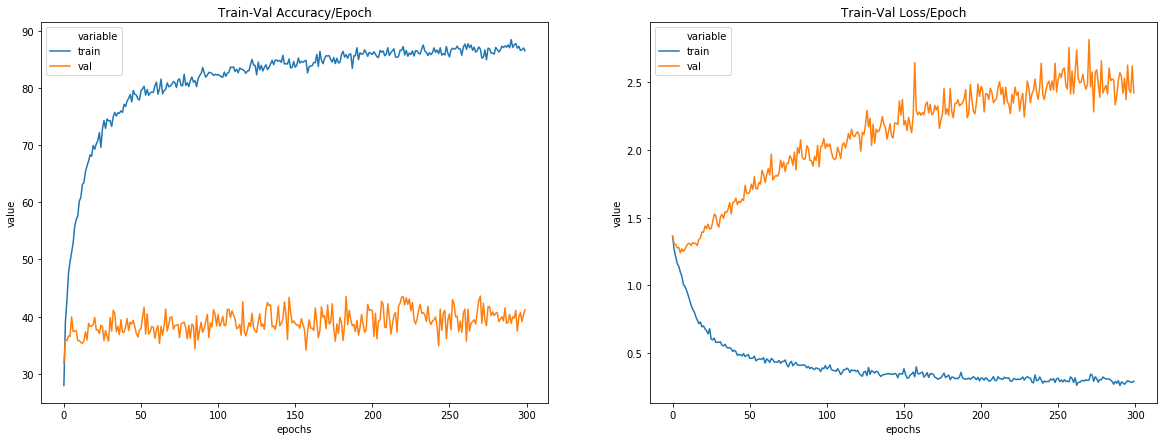

In [83]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Test the model

### test the new PMR data 

In [29]:
test = pd.read_csv('testset_withoutWT.csv')
test

,Unnamed: 0,Pre: Q1,Pre: Q3,L1: Q1,L1: Q3,E1: Q1,E1: Q3,E2: Q1,E2: Q3,E3: Q1,E3: Q3,R1: Q1,R1: Q3,R2: Q1,R2: Q3
0,C1,0.022760,0.025234,0.022922,0.024524,0.023107,0.025042,0.023016,0.025137,0.022669,0.024411,0.022702,0.024123,0.022598,0.024094
1,C4,0.022256,0.025216,0.023978,0.025251,0.025146,0.028801,0.023876,0.027436,0.022252,0.023942,0.022336,0.024188,0.022134,0.023785
2,C6,0.020297,0.023361,0.020478,0.023386,0.020434,0.024109,0.020014,0.023165,0.020023,0.022575,0.020586,0.024104,0.020184,0.022914
3,C7,0.017919,0.019106,0.017926,0.018954,0.017931,0.019289,0.017930,0.018902,0.017882,0.018874,0.017785,0.018622,0.017812,0.018926
4,C8,0.023799,0.026014,0.023703,0.026203,0.023647,0.034638,0.023850,0.030160,0.022710,0.023964,0.022531,0.024691,0.022432,0.023973
5,C14,0.018832,0.021502,0.020516,0.021909,0.019814,0.021256,0.019850,0.022207,0.018725,0.019542,0.018465,0.018842,0.018992,0.019440
6,C16,0.016205,0.017040,0.016681,0.017017,0.016449,0.017081,0.016356,0.016746,0.016249,0.016514,0.016251,0.016534,0.016235,0.016543
7,C18,0.018422,0.021137,0.018822,0.020312,0.021269,0.032057,0.019213,0.021578,0.018676,0.019631,0.018573,0.019775,0.018291,0.019668
8,C19,0.021406,0.024408,0.021994,0.023836,0.022794,0.030129,0.021468,0.024629,0.020861,0.021710,0.020622,0.021531,0.020423,0.021841
9,C32,0.015425,0.017852,0.015560,0.017427,0.015485,0.017377,0.015305,0.016626,0.015414,0.016805,0.015285,0.016545,0.015240,0.016774


In [30]:
Test = test.iloc[:, 1:]
Test

,Pre: Q1,Pre: Q3,L1: Q1,L1: Q3,E1: Q1,E1: Q3,E2: Q1,E2: Q3,E3: Q1,E3: Q3,R1: Q1,R1: Q3,R2: Q1,R2: Q3
0,0.022760,0.025234,0.022922,0.024524,0.023107,0.025042,0.023016,0.025137,0.022669,0.024411,0.022702,0.024123,0.022598,0.024094
1,0.022256,0.025216,0.023978,0.025251,0.025146,0.028801,0.023876,0.027436,0.022252,0.023942,0.022336,0.024188,0.022134,0.023785
2,0.020297,0.023361,0.020478,0.023386,0.020434,0.024109,0.020014,0.023165,0.020023,0.022575,0.020586,0.024104,0.020184,0.022914
3,0.017919,0.019106,0.017926,0.018954,0.017931,0.019289,0.017930,0.018902,0.017882,0.018874,0.017785,0.018622,0.017812,0.018926
4,0.023799,0.026014,0.023703,0.026203,0.023647,0.034638,0.023850,0.030160,0.022710,0.023964,0.022531,0.024691,0.022432,0.023973
5,0.018832,0.021502,0.020516,0.021909,0.019814,0.021256,0.019850,0.022207,0.018725,0.019542,0.018465,0.018842,0.018992,0.019440
6,0.016205,0.017040,0.016681,0.017017,0.016449,0.017081,0.016356,0.016746,0.016249,0.016514,0.016251,0.016534,0.016235,0.016543
7,0.018422,0.021137,0.018822,0.020312,0.021269,0.032057,0.019213,0.021578,0.018676,0.019631,0.018573,0.019775,0.018291,0.019668
8,0.021406,0.024408,0.021994,0.023836,0.022794,0.030129,0.021468,0.024629,0.020861,0.021710,0.020622,0.021531,0.020423,0.021841
9,0.015425,0.017852,0.015560,0.017427,0.015485,0.017377,0.015305,0.016626,0.015414,0.016805,0.015285,0.016545,0.015240,0.016774


In [31]:
Y_test = np.zeros(13)

In [32]:
Y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [33]:
scaler = MinMaxScaler()
Test = scaler.fit_transform(Test)
Test, Y_test = np.array(Test), np.array(Y_test)

In [34]:
Test_dataset = ClassifierDataset(torch.from_numpy(Test).float(), torch.from_numpy(Y_test).long())

In [35]:
Test_loader = DataLoader(dataset=Test_dataset, batch_size=1)
for i in Test_loader:
    print(i)

[tensor([[0.8760, 0.7057, 0.8746, 0.7776, 0.4725, 0.0663, 0.8996, 0.6289, 0.9944,
         1.0000, 1.0000, 0.7998, 1.0000, 0.9411]]), tensor([0])]
[tensor([[0.8158, 0.7042, 1.0000, 0.8529, 0.5989, 0.0976, 1.0000, 0.7987, 0.9372,
         0.9406, 0.9507, 0.8066, 0.9370, 0.9025]]), tensor([0])]
[tensor([[0.5819, 0.5444, 0.5842, 0.6597, 0.3068, 0.0585, 0.5494, 0.4832, 0.6317,
         0.7675, 0.7147, 0.7978, 0.6719, 0.7940]]), tensor([0])]
[tensor([[0.2979, 0.1780, 0.2810, 0.2006, 0.1517, 0.0184, 0.3062, 0.1682, 0.3383,
         0.2988, 0.3371, 0.2200, 0.3496, 0.2970]]), tensor([0])]
[tensor([[1.0000, 0.7729, 0.9673, 0.9515, 0.5060, 0.1462, 0.9969, 1.0000, 1.0000,
         0.9434, 0.9769, 0.8596, 0.9774, 0.9259]]), tensor([0])]
[tensor([[0.4069, 0.3843, 0.5887, 0.5067, 0.2684, 0.0348, 0.5302, 0.4124, 0.4538,
         0.3834, 0.4288, 0.2432, 0.5100, 0.3610]]), tensor([0])]
[tensor([[0.0932, 0.0000, 0.1332, 0.0000, 0.0598, 0.0000, 0.1226, 0.0089, 0.1144,
         0.0000, 0.1303, 0.0000, 0.1

In [36]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in Test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [37]:
y_pred_list

[2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2]

In [38]:
le.inverse_transform(y_pred_list)

array(['TRPV agonist', 'TRPV agonist', 'TRPV agonist', 'TRPV agonist',
       'TRPV agonist', 'TRPV agonist', 'GABAA pore blocker',
       'TRPV agonist', 'TRPV agonist', 'TRPV agonist', 'WT_control',
       'TRPV agonist', 'TRPV agonist'], dtype=object)

In [39]:
# test again


In [40]:
test = pd.read_csv('testset.csv')
test

,Unnamed: 0,Pre: Q1,Pre: Q3,L1: Q1,L1: Q3,E1: Q1,E1: Q3,E2: Q1,E2: Q3,E3: Q1,E3: Q3,R1: Q1,R1: Q3,R2: Q1,R2: Q3
0,C1,0.022760,0.025234,0.022922,0.024524,0.023107,0.025042,0.023016,0.025137,0.022669,0.024411,0.022702,0.024123,0.022598,0.024094
1,C4,0.022256,0.025216,0.023978,0.025251,0.025146,0.028801,0.023876,0.027436,0.022252,0.023942,0.022336,0.024188,0.022134,0.023785
2,C6,0.020297,0.023361,0.020478,0.023386,0.020434,0.024109,0.020014,0.023165,0.020023,0.022575,0.020586,0.024104,0.020184,0.022914
3,C7,0.017919,0.019106,0.017926,0.018954,0.017931,0.019289,0.017930,0.018902,0.017882,0.018874,0.017785,0.018622,0.017812,0.018926
4,C8,0.023799,0.026014,0.023703,0.026203,0.023647,0.034638,0.023850,0.030160,0.022710,0.023964,0.022531,0.024691,0.022432,0.023973
5,C14,0.018832,0.021502,0.020516,0.021909,0.019814,0.021256,0.019850,0.022207,0.018725,0.019542,0.018465,0.018842,0.018992,0.019440
6,C16,0.016205,0.017040,0.016681,0.017017,0.016449,0.017081,0.016356,0.016746,0.016249,0.016514,0.016251,0.016534,0.016235,0.016543
7,C18,0.018422,0.021137,0.018822,0.020312,0.021269,0.032057,0.019213,0.021578,0.018676,0.019631,0.018573,0.019775,0.018291,0.019668
8,C19,0.021406,0.024408,0.021994,0.023836,0.022794,0.030129,0.021468,0.024629,0.020861,0.021710,0.020622,0.021531,0.020423,0.021841
9,C32,0.015425,0.017852,0.015560,0.017427,0.015485,0.017377,0.015305,0.016626,0.015414,0.016805,0.015285,0.016545,0.015240,0.016774


In [41]:
Test = test.iloc[:, 1:]
Test

,Pre: Q1,Pre: Q3,L1: Q1,L1: Q3,E1: Q1,E1: Q3,E2: Q1,E2: Q3,E3: Q1,E3: Q3,R1: Q1,R1: Q3,R2: Q1,R2: Q3
0,0.022760,0.025234,0.022922,0.024524,0.023107,0.025042,0.023016,0.025137,0.022669,0.024411,0.022702,0.024123,0.022598,0.024094
1,0.022256,0.025216,0.023978,0.025251,0.025146,0.028801,0.023876,0.027436,0.022252,0.023942,0.022336,0.024188,0.022134,0.023785
2,0.020297,0.023361,0.020478,0.023386,0.020434,0.024109,0.020014,0.023165,0.020023,0.022575,0.020586,0.024104,0.020184,0.022914
3,0.017919,0.019106,0.017926,0.018954,0.017931,0.019289,0.017930,0.018902,0.017882,0.018874,0.017785,0.018622,0.017812,0.018926
4,0.023799,0.026014,0.023703,0.026203,0.023647,0.034638,0.023850,0.030160,0.022710,0.023964,0.022531,0.024691,0.022432,0.023973
5,0.018832,0.021502,0.020516,0.021909,0.019814,0.021256,0.019850,0.022207,0.018725,0.019542,0.018465,0.018842,0.018992,0.019440
6,0.016205,0.017040,0.016681,0.017017,0.016449,0.017081,0.016356,0.016746,0.016249,0.016514,0.016251,0.016534,0.016235,0.016543
7,0.018422,0.021137,0.018822,0.020312,0.021269,0.032057,0.019213,0.021578,0.018676,0.019631,0.018573,0.019775,0.018291,0.019668
8,0.021406,0.024408,0.021994,0.023836,0.022794,0.030129,0.021468,0.024629,0.020861,0.021710,0.020622,0.021531,0.020423,0.021841
9,0.015425,0.017852,0.015560,0.017427,0.015485,0.017377,0.015305,0.016626,0.015414,0.016805,0.015285,0.016545,0.015240,0.016774


In [42]:
Y_test = np.zeros(17)

In [43]:
scaler = MinMaxScaler()
Test = scaler.fit_transform(Test)
Test, Y_test = np.array(Test), np.array(Y_test)

Test_dataset = ClassifierDataset(torch.from_numpy(Test).float(), torch.from_numpy(Y_test).long())

Test_loader = DataLoader(dataset=Test_dataset, batch_size=1)

y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in Test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [44]:
y_pred_list

[2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2]

In [45]:
le.inverse_transform(y_pred_list)

array(['TRPV agonist', 'TRPV agonist', 'TRPV agonist', 'TRPV agonist',
       'TRPV agonist', 'TRPV agonist', 'TRPV agonist', 'TRPV agonist',
       'TRPV agonist', 'WT_control', 'WT_control', 'TRPV agonist',
       'TRPV agonist', 'TRPV agonist', 'TRPV agonist', 'TRPV agonist',
       'TRPV agonist'], dtype=object)

In [48]:
test["prediction of action mode"] = le.inverse_transform(y_pred_list)

In [52]:
test.to_csv("prediction of action mode(all fishes).csv", index=None)